# Step 1) Install PlantSeg
Run the following cells one by one to install the plantseg environment (this will take ~2 min)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!mamba install --quiet -c conda-forge h5py requests pyyaml scikit-image tifffile vigra python-elf

In [ ]:
!pip install git+https://github.com/wolny/pytorch-3dunet.git --no-deps --ignore-installed --no-cache-dir -q

In [ ]:
!pip install git+https://github.com/lorenzocerrone/plant-seg.git --no-deps --ignore-installed --no-cache-dir -q

In [ ]:
!gdown 1SGeFkfxKTdaeqRFlY43_7TgNMCwwVusd

# Step 2) Load an image file
To do that you can use the Ui in the left
![alt text](https://drive.google.com/uc?id=153MPtCtfU0824IpsKuNZZE6_dKo8Sq8E)


# Step 3) Run PlantSeg
![alt text](https://raw.githubusercontent.com/hci-unihd/plant-seg/assets/images/main_figure.png)

Loading image...
Running predictions...
2022-09-07 09:23:29,535 [MainThread] INFO PlantSeg - Downloading model files from: 'https://oc.embl.de/index.php/s/61s67Mg5VQy7dh9/download?path=%2FPNAS%2Fconfocal_PNAS_2d&files=' ...
2022-09-07 09:23:38,104 [MainThread] WARNING PlantSeg - Incorrect z-dimension in the patch_shape for the 2D UNet prediction. 80 was given, but has to be 1. Defaulting default value: 1
2022-09-07 09:23:38,111 [MainThread] WARNING PlantSeg - Incorrect z-dimension in the stride_shape for the 2D UNet prediction. 40 was given, but has to be 1. Defaulting default value: 1
2022-09-07 09:23:38,121 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': (1, 160, 160), 'stride_shape': (1, 80, 80), 'skip_shape_check': True}
Running watershed...
Running gasp average...


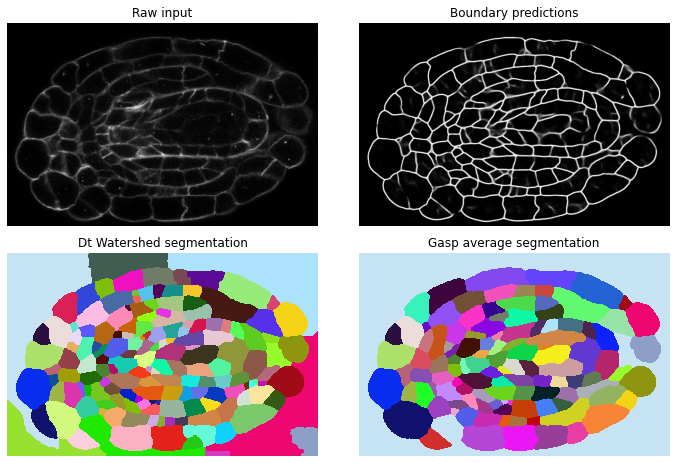

In [5]:
from PIL import Image, ImageOps
import numpy as np
from plantseg.io import smart_load
from plantseg.predictions.functional import unet_predictions
from plantseg.segmentation.functional import gasp, dt_watershed

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def to2d(x):
  x = np.squeeze(x)
  if x.ndim == 3:
    x = x[x.shape[0]//2]

  assert x.ndim == 2
  return x

def plot_results(raw, predictions, dt_seg, gasp_seg):
  color_map = np.random.rand(1000, 3)
  color_map = ListedColormap(color_map) 

  raw = to2d(raw)
  predictions = to2d(predictions)
  dt_seg = to2d(dt_seg)
  gasp_seg = to2d(gasp_seg)
  fig, axes = plt.subplots(2, 2, figsize=(10, 10 * raw.shape[0]/raw.shape[1]))
  
  axes[0, 0].set_title('Raw input')
  axes[0, 0].imshow(raw, cmap='gray')
  axes[0, 0].set_axis_off()

  axes[0, 1].set_title('Boundary predictions')
  axes[0, 1].imshow(predictions, cmap='gray')
  axes[0, 1].set_axis_off()

  axes[1, 0].set_title('Dt Watershed segmentation')
  axes[1, 0].imshow(dt_seg, cmap=color_map, interpolation='nearest')
  axes[1, 0].set_axis_off()

  axes[1, 1].set_title('Gasp average segmentation')
  axes[1, 1].imshow(gasp_seg, cmap=color_map, interpolation='nearest')
  axes[1, 1].set_axis_off()
  fig.tight_layout()
  fig.show()

# Code starts here 
#@markdown ### Enter the file path:
path = 'ovule_sample.tiff' #@param {type:"string"}
#@markdown ### Select hyper-parameters:
model = 'confocal_PNAS_2d' #@param ['confocal_PNAS_2d', 'confocal_2D_unet_bce_dice_ds2x', 'generic_confocal_3d_unet', 'generic_light_sheet_3d_unet']
ws_threshold = 0.5 #@param {type:"slider", min:0.01, max:1, step:0.1}
gasp_under_over_segmentation_factor = 0.6 #@param {type:"slider", min:0.01, max:1, step:0.1}


print('Loading image...')
try:
  raw, _ = smart_load(path)

except:
  print(' failled to use plantseg loader.. trying to load file as png or jpg')
  raw = Image.open(path)
  raw = ImageOps.grayscale(raw)
  raw = np.array(raw)

if raw.ndim == 2 and model in ['generic_confocal_3d_unet', 'generic_light_sheet_3d_unet']:
  raise ValueError('For a 2D image the model selcted should also be 2D')


print('Running predictions...')
predictions = unet_predictions(raw, model_name=model)
print('Running watershed...')
dt_seg = dt_watershed(predictions[0], threshold = ws_threshold)
print('Running gasp average...')
gasp_seg = gasp(predictions[0],
                dt_seg, 
                beta=gasp_under_over_segmentation_factor)

plot_results(raw, predictions, dt_seg, gasp_seg)
